# What is this notebook about?

This notebook is devoted to the problem of subionospheric points (SIP) localization and selection for the region of interest. For sake of generality method described in this notebook will rely on **Navigational** files instead of **Observational** files. This approach makes processing univeral only location of the receiver is needed, but gives the optimal solution (top estimate of data availability): real receiver could not observe the this satellite or data products may not be calculated for this satelitte. 

To illustrate our objective lets use figure below. 

On the left panel we demostrate the GNSS measurements geometry (location of measurements by latitude and longitude). The purple diamond <span style="color:purple;">◆</span> plays role of the epicenter of event. <span style="color:blue;">Blue</span>, <span style="color:red;">red</span> and <span style="color:green;">green</span> lines correspond to the SIPs of three stations <span style="color:blue;">AREC</span>, <span style="color:red;">SCRZ</span>, <span style="color:green;">BRAZ</span>. 

> NOTE: SIP locations depends on our assumption of the height of the effects in the ionosphere

On the right panel we demonstrate the GNSS mesurements by means of ROTI data of the same three stations <span style="color:blue;">AREC</span>, <span style="color:red;">SCRZ</span>, <span style="color:green;">BRAZ</span> versus time. The right panel alone is says nothing about distance from the epicenter. We should utilize sounding geometry to locate the points.

Black circle demonstrate the span of effects from the epicenter (left panel). Black boxes on the right panel demonstrate the data that correspond to the SIPs inside the circle from the left panel. We can see that different **satellite-site** pairs - despite that single satellite shown - come to the proximity of the epicenter at different time.

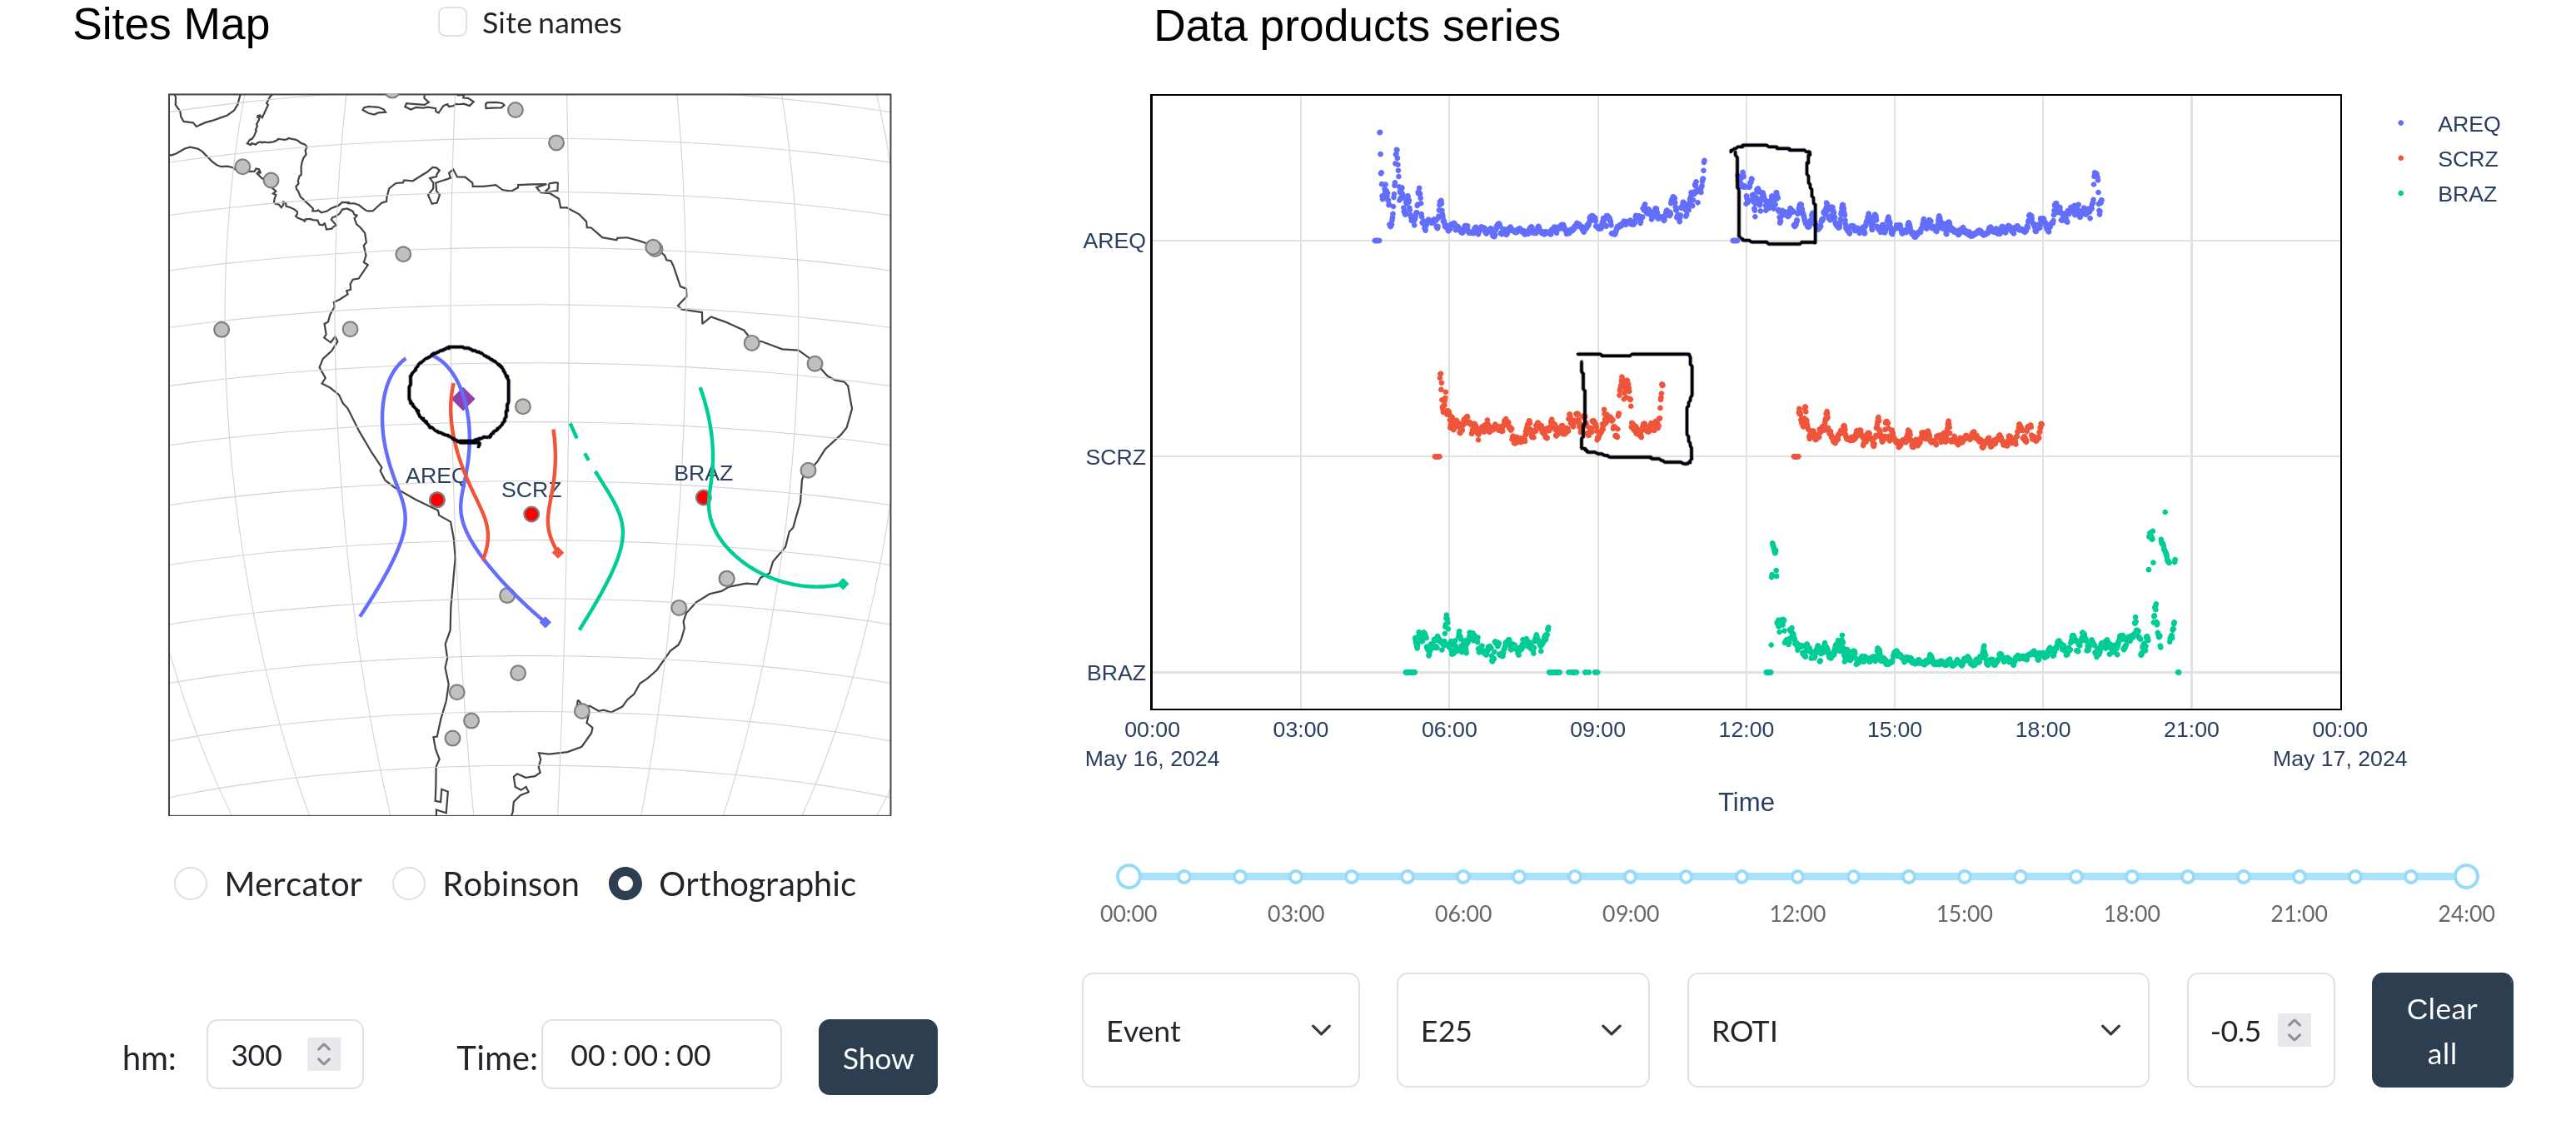


## Input data

### Manually defined

This kind of data - the code below relies on - we cannot guess: (a) event location; (b) max-distance from epicenter (radius of black circle); (c) sites locations; (d) time intervals; (e) list of **ionospheric heights** for which SIP are calculated. 

### Automaticaly retrieved 

This kind of data - the code below relies on - we can retrieve automaticaly: (a) list of satellites; (b) navigational file

## Output data

The output data are list of the vector site-satellite-time-distance for **ionospheric height**. site-satellite-time-distance means that for each **site** we defined when (**time**) and how far (**distance**) SIP of each **satellite** is seen in proximity of the epicenter.